In [1]:
!pip install hyperopt

In [2]:
import os
if os.getcwd().endswith('/notebooks'):
    os.chdir(os.path.join(os.getcwd(), '..'))

In [3]:
train_ds_path = 'output/dataset-200k-noisy.train.csv'
test_ds_path = 'output/dataset-200k-noisy.test.csv'
abbreviation_mapping_path = 'dicts/mle_abbreviation_mapping_from_ani_20190925.csv'

In [4]:
import sys
sys.path.append('.')

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict, OrderedDict
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from classifyGenericModified import ExperimentalClassifier, ExperimentalHybridClassifier
from tqdm import tqdm
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.kernel_approximation import Nystroem
from sklearn.compose import ColumnTransformer
import itertools
import joblib
from model import *
%matplotlib inline
from hyperopt.plotting import *
import numpy as np
from hyperopt import hp, tpe, fmin, Trials
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", ConvergenceWarning)
from collections import OrderedDict
from utils import plot_hyperopt_vars
from joblib import Parallel

In [6]:
ds = pd.read_csv(train_ds_path)

In [7]:
ds.sample(3)

,input,id,label,numdocs
72790,Chemical Works Of Gedeon Richter,NaN,SPE,41.0
9327,Institute of Marine Sciences,60015923.0,GEN,3597.0
16936,National Taitung University,NaN,SPE,1079.0


In [8]:
train_ds, dev_ds = train_test_split(ds, test_size=0.5, stratify=ds.label)

In [9]:
train_ds = train_ds.copy()
dev_ds = dev_ds.copy()

In [10]:
class_weight = {'SPE': 1, 'GEN': 15}

In [11]:
all_available_data = pd.concat([ds, pd.read_csv(test_ds_path)])

In [12]:
len(ds), len(all_available_data)

(90147, 180295)

# Word frequency

In [13]:
tokens = Counter()
for s, c in zip(train_ds.input, train_ds.numdocs):
    for t in s.split():
        # tried adding c instead of 1 but it promotes popular university so much that
        # names frequently pop up in the most common words
        tokens[t.lower()] += 1

In [14]:
tokens_ordered = [t for t, _ in tokens.most_common()]

In [15]:
rule_based_classifier_mono_ling = ExperimentalClassifier('mono', use_multilingual_dicts=False, use_acronym_rule=True, use_zipcode_us_rule=True)
rule_based_classifier_multi_ling = ExperimentalClassifier('multi', use_multilingual_dicts=True, use_acronym_rule=True, use_zipcode_us_rule=True)

Loading dictionary...
Loading dictionary done in 0.78 sec.
Loading dictionary...
Loading dictionary done in 1.37 sec.


In [16]:
num_rules = len(rule_based_classifier_mono_ling.classification_functions)
print('Number of rules:', num_rules)

Number of rules: 26


In [17]:
with open('dicts/topLevelTypes.txt') as f:
    top_level_types = f.read().lower().strip().split()

In [18]:
cl = rule_based_classifier_mono_ling
top_level_words = itertools.chain(cl.cn, cl.univ, cl.companyTypes, top_level_types)
top_level_word_map = {
    w: '^top' for w in top_level_words
}

In [19]:
parallel = Parallel(n_jobs=4, backend='multiprocessing', verbose=0)

In [53]:
def conditional(cond, val):
    if cond:
        return [val]
    else:
        return []

def build_model(hp, verbose=0):
    if hp['rule_cl'] == 'mono_ling':
        rule_based_classifier = rule_based_classifier_mono_ling 
    elif hp['rule_cl'] == 'multi_ling': 
        rule_based_classifier = rule_based_classifier_multi_ling
    else:
        raise ValueError('Invalid choice of rule-based classifier')
        
    word_lists = ([ # later lists have precedence
        ('^L', rule_based_classifier.allLoc),
        ('^sbE', rule_based_classifier.expandedSubjectDict),
        ('^S', rule_based_classifier.subjectDict),
        ('^cS', rule_based_classifier.commonSubjectsDict),
        ('^sb', rule_based_classifier.subjModDict),
        ('^mO', rule_based_classifier.orgModDict),
        ('^cn', rule_based_classifier.cn),
        ('^univ', rule_based_classifier.univ),
        ('^cnS', rule_based_classifier.companySuffixes),
        ('^cnT', rule_based_classifier.companyTypes),
        ('^T', rule_based_classifier.typeDict),
        ('^e', rule_based_classifier.wordEndingsDict),
        ('^sw', rule_based_classifier.sw),
    ] + 
    ([('^lf', tokens_ordered[10000:])] if hp['lf'] else []) +
    [
        ('^and', 'and|&|y|und|e|og|i|και|ja|et|és|en|ból|ve'.split('|')),
        ('^of', 'of|de|des|der|di|fur|fr|for|für|voor|in|zu|és'.split('|')),
        ('^in', 'in|a|op|zu'.split('|')),
        ('^lat', 'I|II|III|IV|V|VI|VII|VIII|IX|X|XI|XII|XIII|XIV|XV|XVI|XVII|XVIII|XIX|XX'.split('|')),
    ])
    word2tag = {}
    for name, word_list in word_lists:
        # word lists from ExperimentalClassifier are preprocessed already, 
        # strings were lower-cased and there are no duplicates
        for w in word_list:
            if w:
                # ideally, each word occurs in only one list
                # in reality, it's commonly that they occur in many lists
                word2tag[w] = name    
    
    rule_encoder = OneHotEncoder(handle_unknown='ignore')
    freq_number_vectorizer_func = lambda: CountVectorizer(analyzer=identity_analyzer, max_features=20, binary=True)
    ngram_pattern_vectorizer = CountVectorizer(analyzer=identity_analyzer, ngram_range=(2,5), min_df=10, binary=True)
    joined_pattern_vectorizer = CountVectorizer(analyzer=identity_analyzer, min_df=20, binary=True)
    ngram_pattern_vectorizer2 = CountVectorizer(analyzer=identity_analyzer, ngram_range=(2,5), min_df=10, binary=True)
    joined_pattern_vectorizer2 = CountVectorizer(analyzer=identity_analyzer, min_df=20, binary=True)
    discretizer = KBinsDiscretizer(n_bins=hp['nbins'], encode='onehot', strategy='quantile')
    feature_extractor = FeatureUnion([
        ('string_feats', make_pipeline(
            ItemSelector(0),
            TokenTranslator(abbreviation_mapping_path),
            FeatureUnion(
                [
                    ('freq-char-len', make_pipeline(CharLenFeature(), freq_number_vectorizer_func())),
                    ('freq-word-len', make_pipeline(WordLenFeature(), freq_number_vectorizer_func())),
                ] + 
                conditional(hp['freq-min-word-freq'], 
                    ('freq-min-word-freq', make_pipeline(WordFrequencyFeatures(tokens, stats=['min']), 
                                                         freq_number_vectorizer_func()))) +
                conditional(hp['freq-max-word-freq'],
                    ('freq-max-word-freq', make_pipeline(WordFrequencyFeatures(tokens, stats=['max']), 
                                                         freq_number_vectorizer_func()))) +
                [('numerical-discretized', make_pipeline(
                        FeatureUnion([
                            ('char_len', CharLenFeature()),
                            ('word_len', WordLenFeature()),
                            ('freq_upper', FreqCapitalsFeature()),
                            ('word_freq', WordFrequencyFeatures(tokens, stats=['mean'])),
                        ]),
                        discretizer,
                    )),
                ] +
                conditional(hp['word_list'],
                    ('word_list', make_pipeline(
                        # didn't use num_top_freq_words because I don't want to override "^top" tags
                        WordListTagger(word2tag, 0, default_tag='^nf'),
                        FeatureUnion([
                            ('joined', make_pipeline(StringConcat(), joined_pattern_vectorizer)),
                            ('n-grams', ngram_pattern_vectorizer)
                        ])
                    ))) +
                conditional(hp['word_list_top_freq'], 
                    ('word_list_top_freq', make_pipeline(
                        WordListTagger(word2tag, 100, default_tag='^nf'),
                        FeatureUnion([
                            ('joined', make_pipeline(StringConcat(), joined_pattern_vectorizer2)),
                            ('n-grams', ngram_pattern_vectorizer2)
                        ])
                    ))) +
                conditional(hp['top_level_word'], 
                    ('top_level_word', make_pipeline( # check for words such as "university", "institution", "ltd."
                        WordListTagger(top_level_word_map, 1000, default_tag='other'),
                        CountVectorizer(analyzer=identity_analyzer, ngram_range=(1,3), binary=True)
                    )))
            )
        )),
        ('rule_feats', make_pipeline(
            ItemSelector(1), RuleFeatures(), rule_encoder
        ))
    ])
    if hp['kernel']:
        feature_extractor = make_pipeline(feature_extractor, Nystroem(**hp['kernel']))
    classifier = LinearSVC(class_weight=class_weight, C=hp['C'], verbose=verbose)
    rule_mask = [hp['rule_%02d'%i] for i in range(num_rules)]
    hybrid_classifier = ExperimentalHybridClassifier(rule_based_classifier, feature_extractor, classifier, rule_mask)
    return hybrid_classifier, classifier, feature_extractor
    
    
def negative_f1_on_dev_sample(hp, f1_beta=1, sample_frac=0.1):
    batch_size = 10000 # smaller batch size would turn on multiprocessing which actually makes it slower
    hybrid_classifier, _, _ = build_model(hp)
    if sample_frac is None or sample_frac == 1:
        train_sample, dev_sample = train_ds, dev_ds
    else:
        _, train_sample = train_test_split(train_ds, test_size=sample_frac, stratify=train_ds.label)
        _, dev_sample = train_test_split(dev_ds, test_size=sample_frac, stratify=dev_ds.label)
    hybrid_classifier.fit(train_sample.input, train_sample.label, parallel, 
                          sample_weight=train_sample.numdocs, batch_size=batch_size)
    predictions = hybrid_classifier.classifyOrgBatch(dev_sample.input, parallel, batch_size)
    _, _, (f1,), _ = precision_recall_fscore_support(dev_sample.label, predictions, beta=f1_beta, labels=['GEN'],
                                                     sample_weight=dev_sample.numdocs)
    return -f1

# Hyperparam search

## With kernels

In [54]:
kernel_vals = [ 
    {'kernel': 'poly', 'degree': 2},
    {'kernel': 'poly', 'degree': 3},
    {'kernel': 'rbf'},
]
nbins_vals = [2, 3, 4]
rule_vals = ['mono_ling', 'multi_ling']
rule_vars = {
    'rule_%02d'%i: hp.choice('rule_%02d'%i, [False, True])
    for i in range(num_rules)
}
search_space = {
    'lf': hp.choice('lf', [False, True]),
    'freq-min-word-freq': hp.choice('freq-min-word-freq', [False, True]),
    'freq-max-word-freq': hp.choice('freq-max-word-freq', [False, True]),
    'word_list': hp.choice('word_list', [False, True]),
    'word_list_top_freq': hp.choice('word_list_top_freq', [False, True]),
    'top_level_word': hp.choice('top_level_word', [False, True]),
    'nbins': hp.choice('nbins', nbins_vals),
    'rule_cl': hp.choice('rule_cl', rule_vals),
    'kernel': hp.choice('kernel', kernel_vals),
    'C': hp.loguniform('C', 0, 5),
    **rule_vars
}

In [55]:
trials = Trials()
best = fmin(fn=negative_f1_on_dev_sample, space=search_space,
            algo=tpe.suggest, max_evals=200, trials=trials)

100%|██████████| 200/200 [13:49<00:00,  4.15s/it, best loss: -0.9815957854862295]


In [56]:
best

{'C': 79.2072764695238,
 'freq-max-word-freq': 1,
 'freq-min-word-freq': 1,
 'kernel': 0,
 'lf': 1,
 'nbins': 0,
 'rule_00': 1,
 'rule_01': 0,
 'rule_02': 1,
 'rule_03': 0,
 'rule_04': 0,
 'rule_05': 1,
 'rule_06': 0,
 'rule_07': 1,
 'rule_08': 0,
 'rule_09': 1,
 'rule_10': 1,
 'rule_11': 1,
 'rule_12': 0,
 'rule_13': 0,
 'rule_14': 1,
 'rule_15': 0,
 'rule_16': 1,
 'rule_17': 0,
 'rule_18': 0,
 'rule_19': 1,
 'rule_20': 1,
 'rule_21': 0,
 'rule_22': 1,
 'rule_23': 1,
 'rule_24': 0,
 'rule_25': 1,
 'rule_cl': 0,
 'top_level_word': 1,
 'word_list': 0,
 'word_list_top_freq': 0}

## Without kernels

In [57]:
kernel_vals = [None]
nbins_vals = [2, 3, 4]
rule_vals = ['mono_ling', 'multi_ling']
rule_vars = {
    'rule_%02d'%i: hp.choice('rule_%02d'%i, [False, True])
    for i in range(num_rules)
}
search_space = {
    'lf': hp.choice('lf', [False, True]),
    'freq-min-word-freq': hp.choice('freq-min-word-freq', [False, True]),
    'freq-max-word-freq': hp.choice('freq-max-word-freq', [False, True]),
    'word_list': hp.choice('word_list', [False, True]),
    'word_list_top_freq': hp.choice('word_list_top_freq', [False, True]),
    'top_level_word': hp.choice('top_level_word', [False, True]),
    'nbins': hp.choice('nbins', nbins_vals),
    'rule_cl': hp.choice('rule_cl', rule_vals),
    'kernel': hp.choice('kernel', kernel_vals),
    'C': hp.loguniform('C', 0, 5),
    **rule_vars
}

In [58]:
trials = Trials()
best = fmin(fn=negative_f1_on_dev_sample, space=search_space,
            algo=tpe.suggest, max_evals=100, trials=trials)

100%|██████████| 100/100 [05:50<00:00,  3.51s/it, best loss: -0.9761126284467184]


In [59]:
best

{'C': 3.6149783307147487,
 'freq-max-word-freq': 1,
 'freq-min-word-freq': 0,
 'kernel': 0,
 'lf': 1,
 'nbins': 1,
 'rule_00': 0,
 'rule_01': 0,
 'rule_02': 0,
 'rule_03': 0,
 'rule_04': 0,
 'rule_05': 0,
 'rule_06': 0,
 'rule_07': 1,
 'rule_08': 0,
 'rule_09': 1,
 'rule_10': 1,
 'rule_11': 1,
 'rule_12': 1,
 'rule_13': 1,
 'rule_14': 0,
 'rule_15': 0,
 'rule_16': 0,
 'rule_17': 1,
 'rule_18': 0,
 'rule_19': 0,
 'rule_20': 1,
 'rule_21': 1,
 'rule_22': 0,
 'rule_23': 1,
 'rule_24': 0,
 'rule_25': 0,
 'rule_cl': 1,
 'top_level_word': 1,
 'word_list': 1,
 'word_list_top_freq': 1}

finite loss range -0.9761126284467184 -0.6104939798336076 -1.9761126284467183


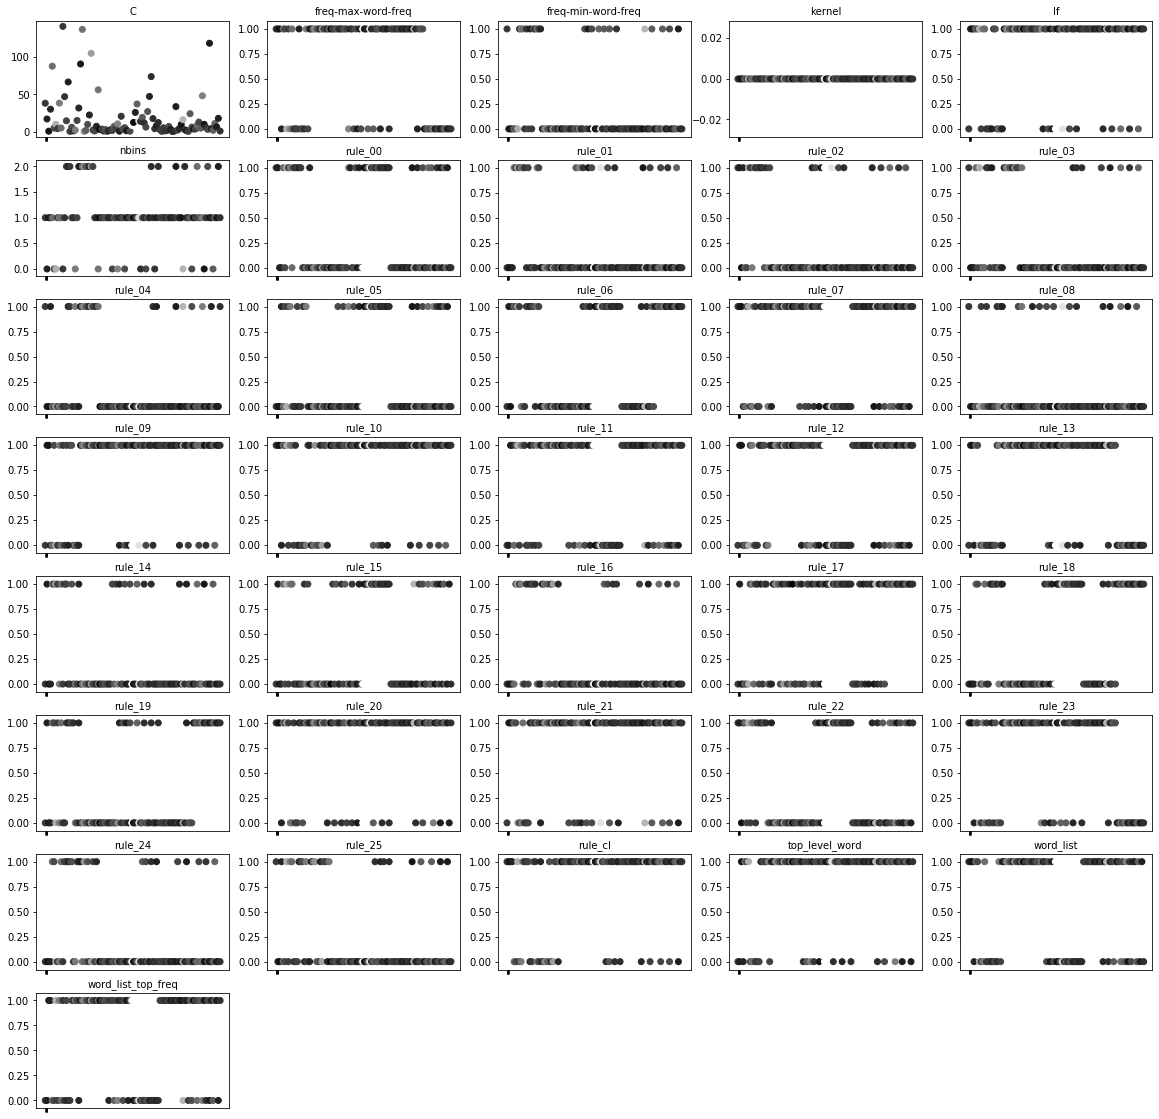

In [60]:
plot_hyperopt_vars(trials, columns=5)

avg best error: -0.9761126284467184


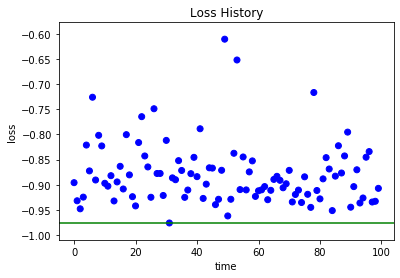

In [61]:
main_plot_history(trials)

## Train some models for testing in a different notebook

In [62]:
best_rule_vars = {
    'rule_%02d'%i: best['rule_%02d'%i]
    for i in range(num_rules)
}
# hyperparams are selected manually based on the plot above, 
# not necessary the content of `best` because the negative F1
# calculated is stochastic (based on a small sample)
chosen_hyperparams = {
    'C': 10,
    'freq-max-word-freq': 0,
    'freq-min-word-freq': 1,
    'kernel': None,
    'lf': 0,
    'nbins': nbins_vals[2],
    'rule_cl': rule_vals[0],
    'top_level_word': 0,
    'word_list': 1,
    'word_list_top_freq': 1,
    **best_rule_vars
}

In [63]:
%%time
hybrid_classifier, _, feature_extractor = build_model(chosen_hyperparams)
hybrid_classifier.fit(ds.input, ds.label, parallel, sample_weight=None)

CPU times: user 37.9 s, sys: 1.5 s, total: 39.4 s
Wall time: 38.7 s


In [64]:
joblib.dump(feature_extractor, 'output/feature_extractor-linear.pkl')
joblib.dump(hybrid_classifier, 'output/hybrid_classifier-linear-trained_on_100k.pkl')
del hybrid_classifier
del feature_extractor

In [65]:
%%time
hybrid_classifier_weighted, _, _ = build_model(chosen_hyperparams)
hybrid_classifier_weighted.fit(ds.input, ds.label, parallel, sample_weight=ds.numdocs)

CPU times: user 35.9 s, sys: 1.3 s, total: 37.2 s
Wall time: 36.5 s


In [66]:
joblib.dump(hybrid_classifier_weighted, 'output/hybrid_classifier-linear-weighted-trained_on_100k.pkl')

['output/hybrid_classifier-linear-weighted-trained_on_100k.pkl']

# Train models on all available datasets

They won't be used on intrinsic evaluation but on end-to-end evaluation

## Without kernels

In [67]:
# hyperparams are selected manually based on the plot above, 
# not necessary the content of `best` because the negative F1
# calculated is stochastic (based on a small sample)
chosen_hyperparams = {
    'C': 10,
    'freq-max-word-freq': 0,
    'freq-min-word-freq': 1,
    'kernel': None,
    'lf': 0,
    'nbins': nbins_vals[2],
    'rule_cl': rule_vals[0],
    'top_level_word': 0,
    'word_list': 1,
    'word_list_top_freq': 1,
     'rule_00': 0, # cl_empty
     'rule_01': 0,
     'rule_02': 0,
     'rule_03': 0,
     'rule_04': 0,
     'rule_05': 1,
     'rule_06': 1,
     'rule_07': 1,
     'rule_08': 0,
     'rule_09': 0,
     'rule_10': 0,
     'rule_11': 0,
     'rule_12': 1,
     'rule_13': 1,
     'rule_14': 0,
     'rule_15': 0,
     'rule_16': 1,
     'rule_17': 1,
     'rule_18': 1,
     'rule_19': 0,
     'rule_20': 0,
     'rule_21': 1,
     'rule_22': 0,
     'rule_23': 1,
     'rule_24': 0,
     'rule_25': 0, # default: always 'GEN'
}

In [68]:
# import classifyGenericModified
# import importlib
# importlib.reload(classifyGenericModified)
# from classifyGenericModified import ExperimentalClassifier, ExperimentalHybridClassifier, normalizeName

In [69]:
%%time
hybrid_classifier, _, _ = build_model(chosen_hyperparams)
hybrid_classifier.fit(all_available_data.input, all_available_data.label, parallel, sample_weight=None)

CPU times: user 1min 25s, sys: 2.74 s, total: 1min 27s
Wall time: 1min 28s


In [70]:
print('Selected rules:', ', '.join(f.__name__ for f in hybrid_classifier.rfuncs))

Selected rules: cl_cn, cl_company_types, cl_university, cl_department3, cl_department4, cl_department7, cl_department8, cl_subj, cl_hospital, cl_bag_of_known_words2


In [71]:
len(hybrid_classifier.rfuncs)

10

In [72]:
joblib.dump(hybrid_classifier, 'output/hybrid_classifier-linear.pkl')

['output/hybrid_classifier-linear.pkl']

In [73]:
%%time
hybrid_classifier_weighted, _, _ = build_model(chosen_hyperparams)
hybrid_classifier_weighted.fit(all_available_data.input, all_available_data.label, parallel, 
                               sample_weight=all_available_data.numdocs)

CPU times: user 1min 24s, sys: 2.7 s, total: 1min 27s
Wall time: 1min 29s


In [74]:
joblib.dump(hybrid_classifier_weighted, 'output/hybrid_classifier-linear-weighted.pkl')

['output/hybrid_classifier-linear-weighted.pkl']

In [75]:
%%time
chosen_hyperparams['rule_cl'] = rule_vals[1] # multilingual
hybrid_classifier_weighted_multiling, _, _ = build_model(chosen_hyperparams)
hybrid_classifier_weighted_multiling.fit(all_available_data.input, all_available_data.label, parallel, 
                               sample_weight=all_available_data.numdocs)

CPU times: user 1min 18s, sys: 2.78 s, total: 1min 21s
Wall time: 1min 22s


In [76]:
joblib.dump(hybrid_classifier_weighted_multiling, 'output/hybrid_classifier-linear-weighted-multiling.pkl')

['output/hybrid_classifier-linear-weighted-multiling.pkl']